In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

In [2]:
env = gym.make("LunarLander-v2", render_mode = 'rgb_array')
observation, info = env.reset()

In [3]:
class ActorNet(nn.Module):
    def __init__(self, hidden_dim=32):
        super().__init__()
        self.hidden = nn.Linear(env.observation_space.shape[0], hidden_dim)
        self.medium = nn.Linear(hidden_dim, hidden_dim)
        self.action_vals = nn.Linear(hidden_dim, env.action_space.n)

    def forward(self, s):
        outs = F.elu(self.hidden(torch.tensor(s)))
        outs = F.elu(self.medium(outs))
        logits = F.elu(self.action_vals(outs))
        return logits
    
    def sample_action(self, state):
        with torch.no_grad():
            s = torch.tensor(state)
            logits = self.forward(s)
            probs = torch.softmax(logits, dim = -1)
            action = torch.multinomial(probs, 1).item()
            return action

class CriticNet(nn.Module):
    def __init__(self, hidden_dim=32):
        super().__init__()
        self.hidden = nn.Linear(env.observation_space.shape[0], hidden_dim)
        self.medium = nn.Linear(hidden_dim, hidden_dim)
        self.vals = nn.Linear(hidden_dim, 1)

    def forward(self, s):
        outs = F.elu(self.hidden(torch.tensor(s)))
        outs = F.elu(self.medium(outs))
        values = F.elu(self.vals(outs))
        return values
actor = ActorNet()
critic = CriticNet()

In [4]:
checkpoint = torch.load('actor_critic_lander')
actor.load_state_dict(checkpoint['ActorNet_state_dict'])
critic.load_state_dict(checkpoint['CriticNet_state_dict'])

<All keys matched successfully>

In [7]:
import time
from IPython import display as ipythondisplay
import matplotlib.pyplot as plt

class PeriodicPlotter:
  def __init__(self, sec, xlabel='', ylabel=''):
    self.xlabel = xlabel
    self.ylabel = ylabel
    self.sec = sec
    self.tic = time.time()

  def plot(self, data):
    if time.time() - self.tic > self.sec:
      plt.cla()
      plt.plot(data)
      plt.xlabel(self.xlabel); plt.ylabel(self.ylabel)
      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())
      self.tic = time.time()
plotter = PeriodicPlotter(sec = 2)
reward_records = []

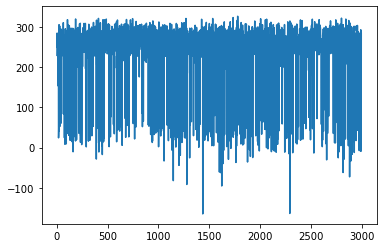

100%|██████████| 3000/3000 [06:49<00:00,  7.33it/s]


Done


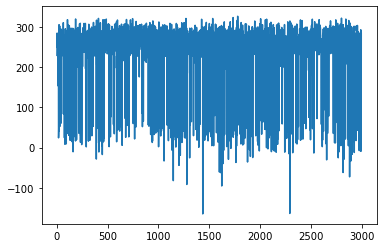

In [8]:
gamma = 0.99

from tqdm import tqdm
opt1 = torch.optim.AdamW(critic.parameters(), lr=0.001)
opt2 = torch.optim.AdamW(actor.parameters(), lr=0.001)

for i in tqdm(range(3000)):
    
    done = False
    states = []
    rewards = []
    actions = []

    s, _ = env.reset()
    while not done:
        states.append(s.tolist())
        a = actor.sample_action(s)
        s, r, term, trunc, _ = env.step(a)
        done = term or trunc
        rewards.append(r)
        actions.append(a)
    
    cum_rewards = np.zeros_like(rewards)
    reward_len = len(rewards)
    for j in reversed(range(reward_len)):
        cum_rewards[j] = rewards[j] + (cum_rewards[j+1]*gamma if j+1 < reward_len else 0)
    
    states = torch.tensor(states, dtype=torch.float)
    cum_rewards = torch.tensor(cum_rewards, dtype=torch.float)
    actions = torch.tensor(actions, dtype = torch.long)
    
    opt1.zero_grad()
    values = critic(states)
    values = values.squeeze(dim=1)
    advantages = cum_rewards - values
    vf_loss = advantages.pow(2).mean()
    vf_loss.backward()
    opt1.step()

    advantages = advantages.detach()
    
    opt2.zero_grad()
    logits = actor(states)
    log_probs = -F.cross_entropy(logits, actions, reduction="none")
    pi_loss = -log_probs * advantages 
    pi_loss.sum().backward()
    opt2.step()

    plotter.plot(reward_records)
    reward_records.append(sum(rewards))

    if np.average(reward_records[-50:]) > 475.0:
        break

print("\nDone")
env.close()

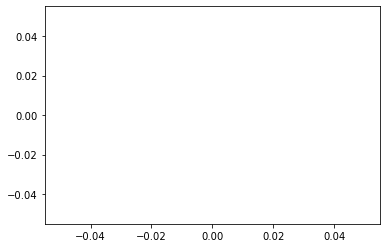

In [8]:
import matplotlib.pyplot as plt
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(reward_records, c = 'orange')
plt.plot(average_reward, c = 'darkviolet')

In [10]:
torch.save({
    'ActorNet_state_dict': actor.state_dict(),
    'CriticNet_state_dict': critic.state_dict(),
    }, 'actor_critic_lander')

In [9]:
# record sessions
from gymnasium.wrappers import RecordVideo

def evaluate(env, agent, n_games=1, t_max=10000, seed=None):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s, _ = env.reset(seed=seed)
        reward = 0
        for _ in range(t_max):
            action = agent.sample_action(s)
            s, r, terminated, truncated, _ = env.step(action)
            reward += r
            if terminated or truncated:
                break
        rewards.append(reward)
    return np.mean(rewards)

with RecordVideo(
    env=env, video_folder="./videos", episode_trigger=lambda episode_number: True
) as env_monitor:
    sessions = [
        evaluate(env_monitor, actor, n_games=1) for _ in range(5)
    ]


/var/folders/_j/n1j73z4j0g14gw6cprm8h7100000gn/T/ipykernel_19618/415827126.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outs = F.elu(self.hidden(torch.tensor(s)))


Moviepy - Building video /Users/jacob/RLWandering/Actor_critic_lander/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/jacob/RLWandering/Actor_critic_lander/videos/rl-video-episode-0.mp4



/var/folders/_j/n1j73z4j0g14gw6cprm8h7100000gn/T/ipykernel_19618/415827126.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outs = F.elu(self.hidden(torch.tensor(s)))


Moviepy - Done !
Moviepy - video ready /Users/jacob/RLWandering/Actor_critic_lander/videos/rl-video-episode-0.mp4
Moviepy - Building video /Users/jacob/RLWandering/Actor_critic_lander/videos/rl-video-episode-1.mp4.
Moviepy - Writing video /Users/jacob/RLWandering/Actor_critic_lander/videos/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /Users/jacob/RLWandering/Actor_critic_lander/videos/rl-video-episode-1.mp4
Moviepy - Building video /Users/jacob/RLWandering/Actor_critic_lander/videos/rl-video-episode-2.mp4.
Moviepy - Writing video /Users/jacob/RLWandering/Actor_critic_lander/videos/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /Users/jacob/RLWandering/Actor_critic_lander/videos/rl-video-episode-2.mp4
Moviepy - Building video /Users/jacob/RLWandering/Actor_critic_lander/videos/rl-video-episode-3.mp4.
Moviepy - Writing video /Users/jacob/RLWandering/Actor_critic_lander/videos/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /Users/jacob/RLWandering/Actor_critic_lander/videos/rl-video-episode-3.mp4
Moviepy - Building video /Users/jacob/RLWandering/Actor_critic_lander/videos/rl-video-episode-4.mp4.
Moviepy - Writing video /Users/jacob/RLWandering/Actor_critic_lander/videos/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /Users/jacob/RLWandering/Actor_critic_lander/videos/rl-video-episode-4.mp4


In [11]:
from pathlib import Path
from IPython.display import HTML
import random 

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[random.choice(range(len(video_paths)))]

data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))